# Dataloading

In [17]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qscaled.preprocessing import (
    bootstrap_crossings, 
    UTDGroupedLoader
)
from qscaled.visualization import (
    plot_per_learning_rate, 
    plot_per_batch_size,
    plot_bootstrap_average_params,
    plot_closest_data_efficiency,
    plot_averaged_data_efficiency
)
from qscaled.bootstrap_envsteps_to_thresh import (
    grid_best_uncertainty_lr,
    grid_best_uncertainty_bs,
    get_bootstrap_optimal,
    compute_bootstrap_averages
)
from qscaled.linear_fit import linear_fit_separate, linear_fit_shared
from qscaled.save_params import tabulate_proposed_params, tabulate_baseline_params

from utils.wandb_utils import CRLRunCollector
from utils.create_zip import save_and_load
from utils.configs import Config

np.random.seed(42)

To use this code:
1. Label your Wandb runs with tags.
2. Fill in `MyRunCollector` in `utils/wandb_utils.py`.
3. Update the following cell.

The latter two steps take ~5 minutes!

If you set `wandb_collect == True`, your `zip` file will be rebuilt using your
Wandb collector. Otherwise, the `zip` file must be present.

In [2]:
wandb_collect = False
name = 'gym_sweep'

if wandb_collect:
    wandb_collector = CRLRunCollector('prestonfu', 'crl').create(
        load=True,
        tags=['sac_grid_manual_250206'],
        path=f'../../cache/collector/{name}.npy',
        parallel=True
    )
    # Remove these lines if you'd like
    wandb_collector.remove_short(0.95)
    wandb_collector.trim(num_seeds=8, verbose=True)
else:
    wandb_collector = None

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is some variation for different environments.

config = Config(
    name=name,
    max_returns={
        "HalfCheetah-v4": 7300 * 1.25,
        "Walker2d-v4": 4000 * 1.25,
        "Ant-v4": 5300 * 1.25,
        "Humanoid-v4": 5200 * 1.25,
    },
    return_key='episode/return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16],
    wandb_collector=wandb_collector
)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

If you used the code above with `save_loop`, use `UTDGroupedLoader` below.
(`FullGroupedLoaderUnlabeled` is used below for DMC data, which was collected independently.)

In [3]:
grid_search_df = save_and_load(config)
grid_search_df = bootstrap_crossings(
    grid_search_df, 
    config.thresholds, 
    bootstrap_cache_file=f'../../cache/bootstrap_results/{name}.pkl'
)

Average standard deviation across all conditions: 2771.15


# Visualization

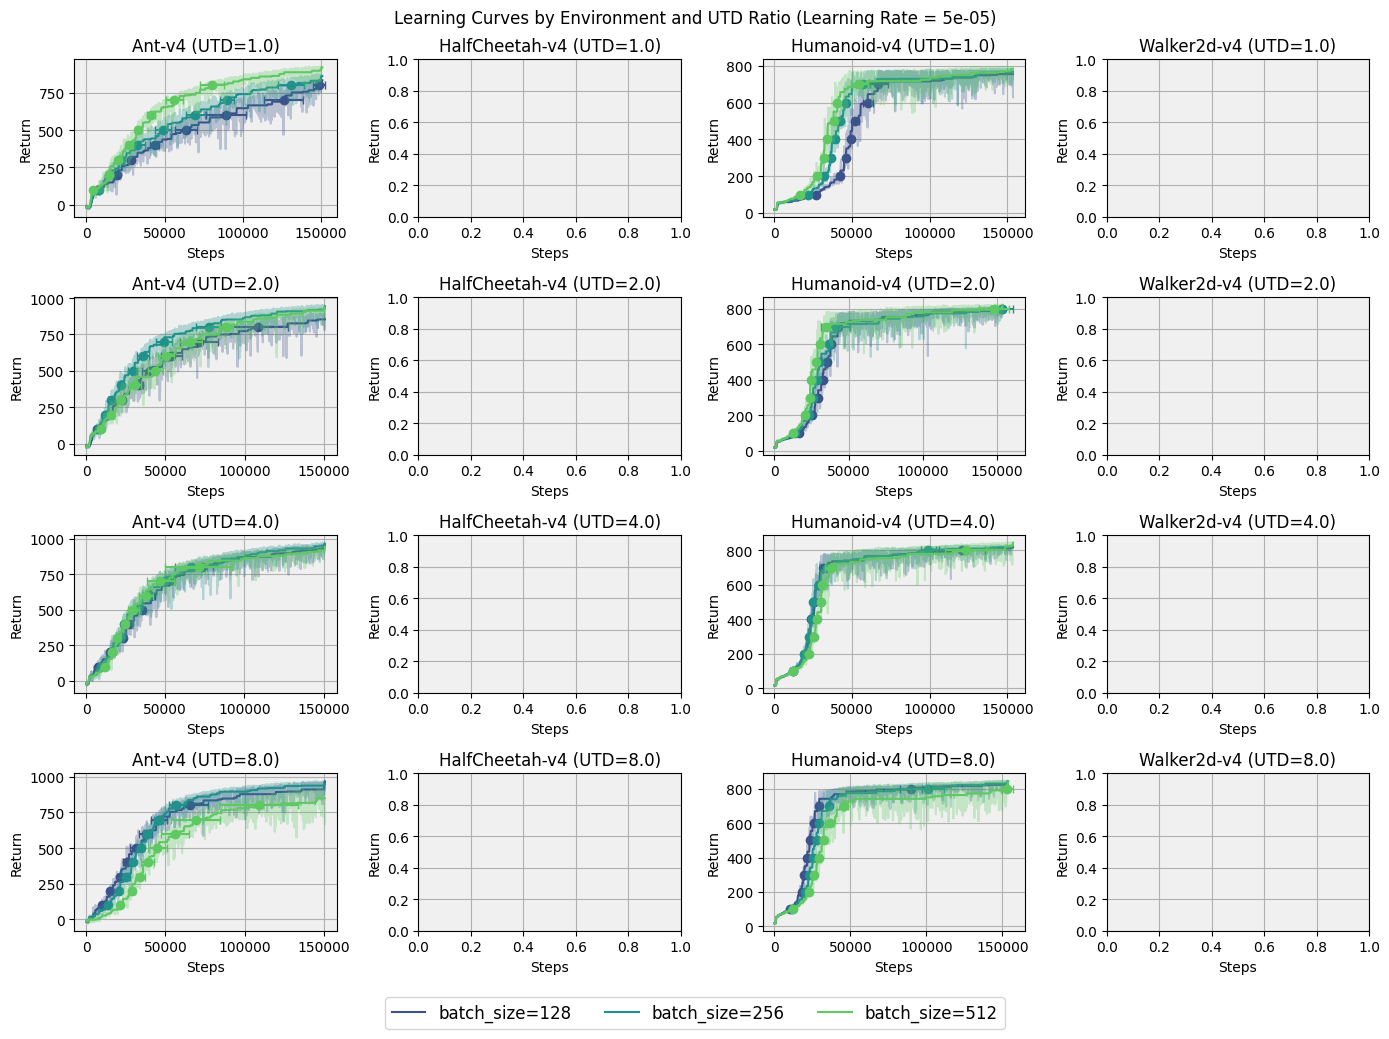

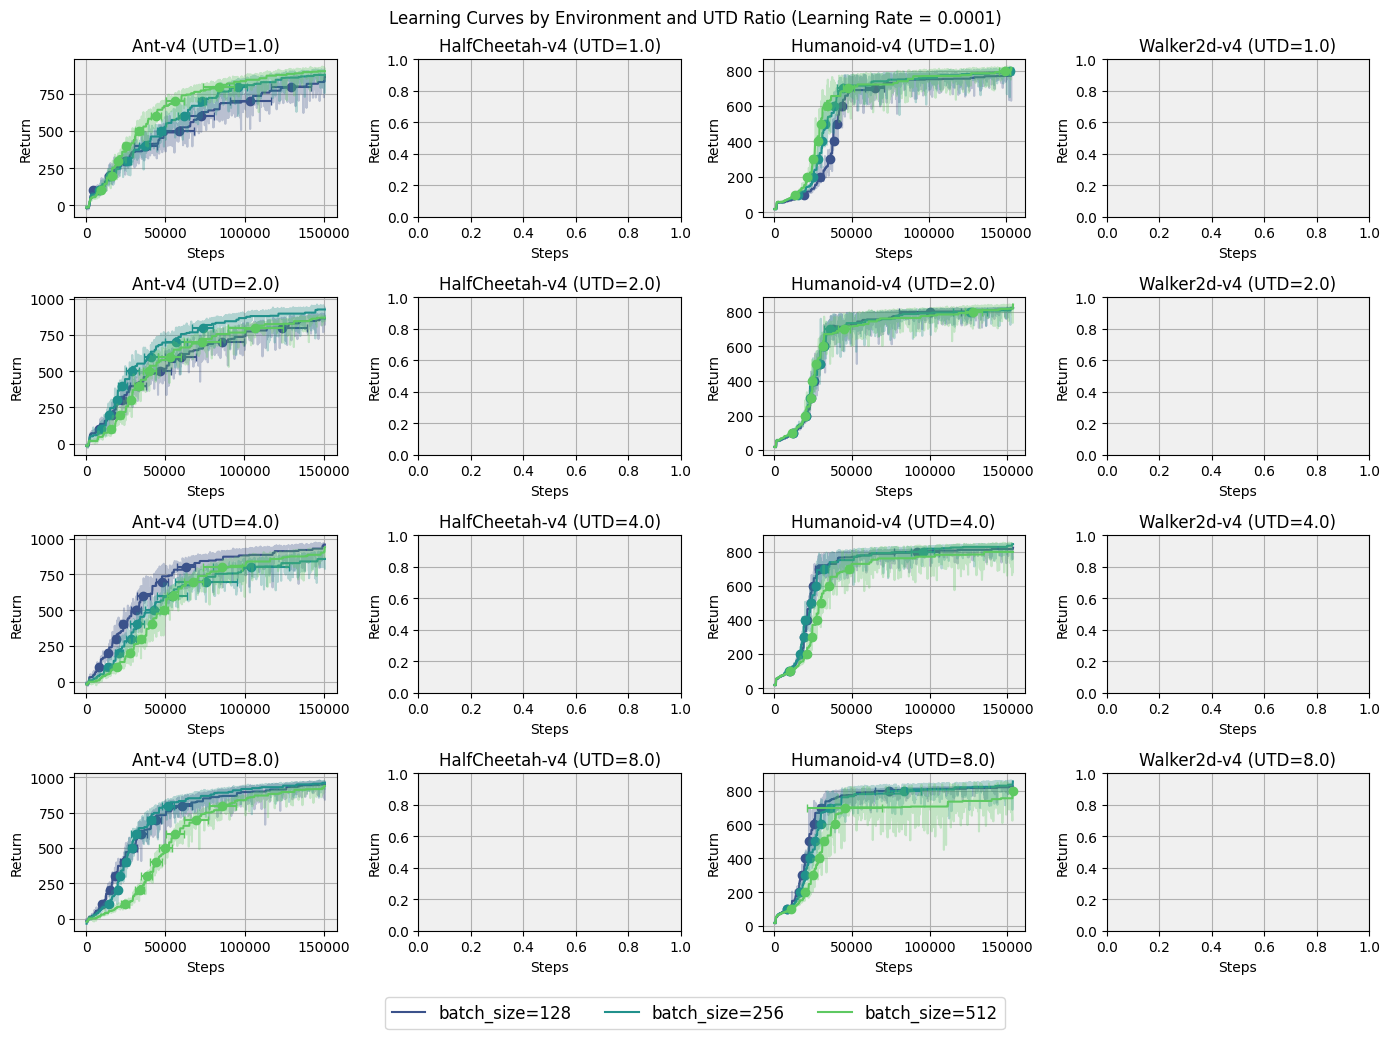

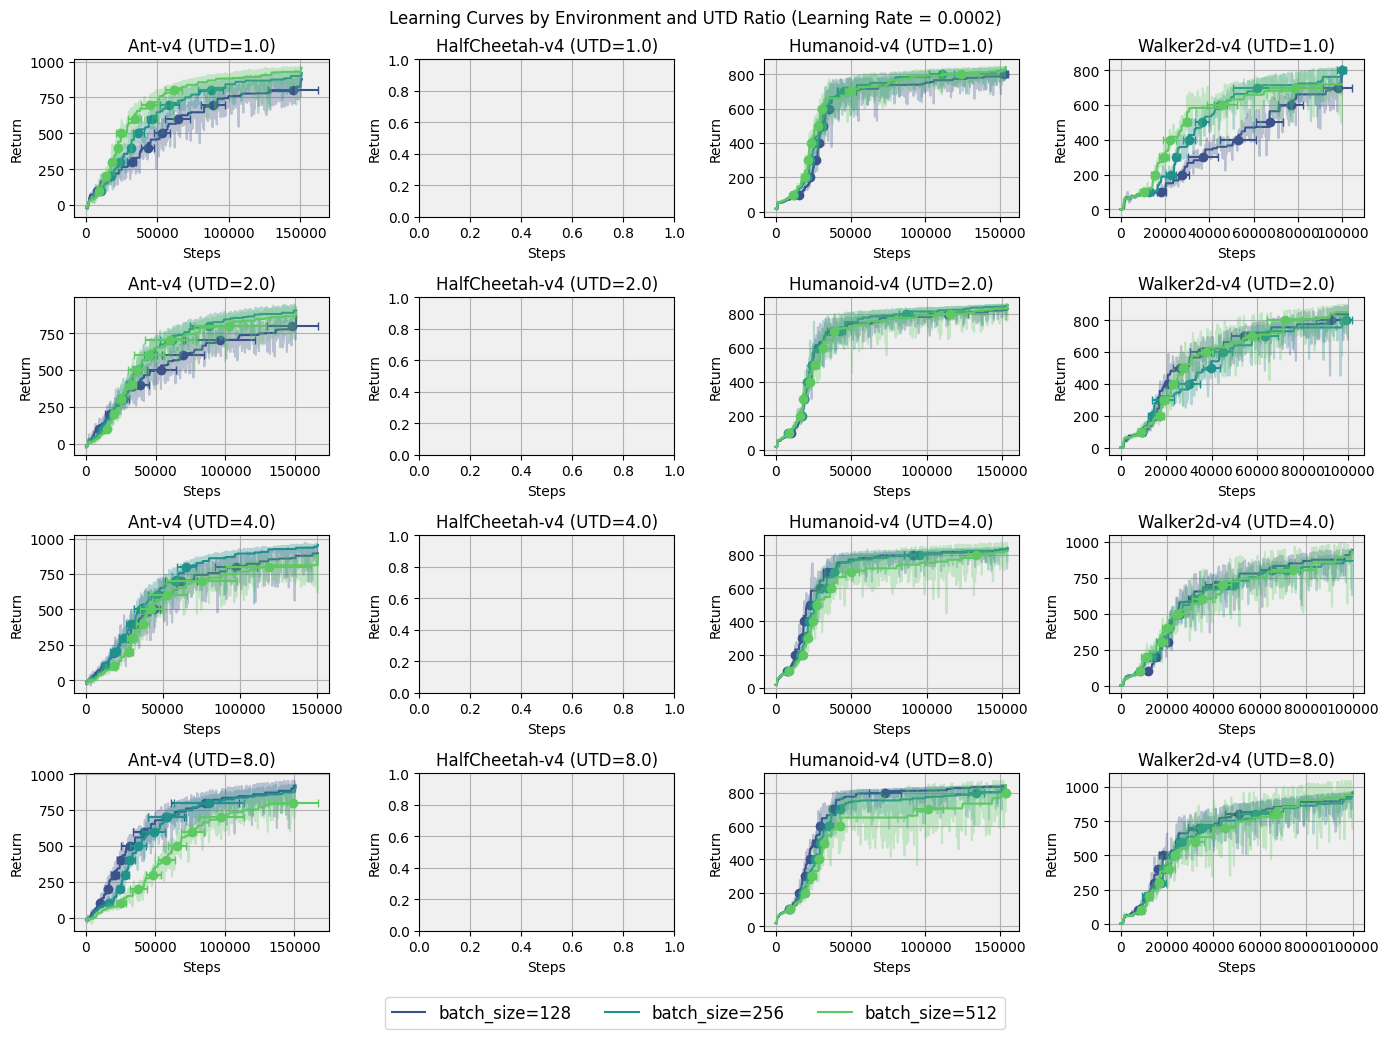

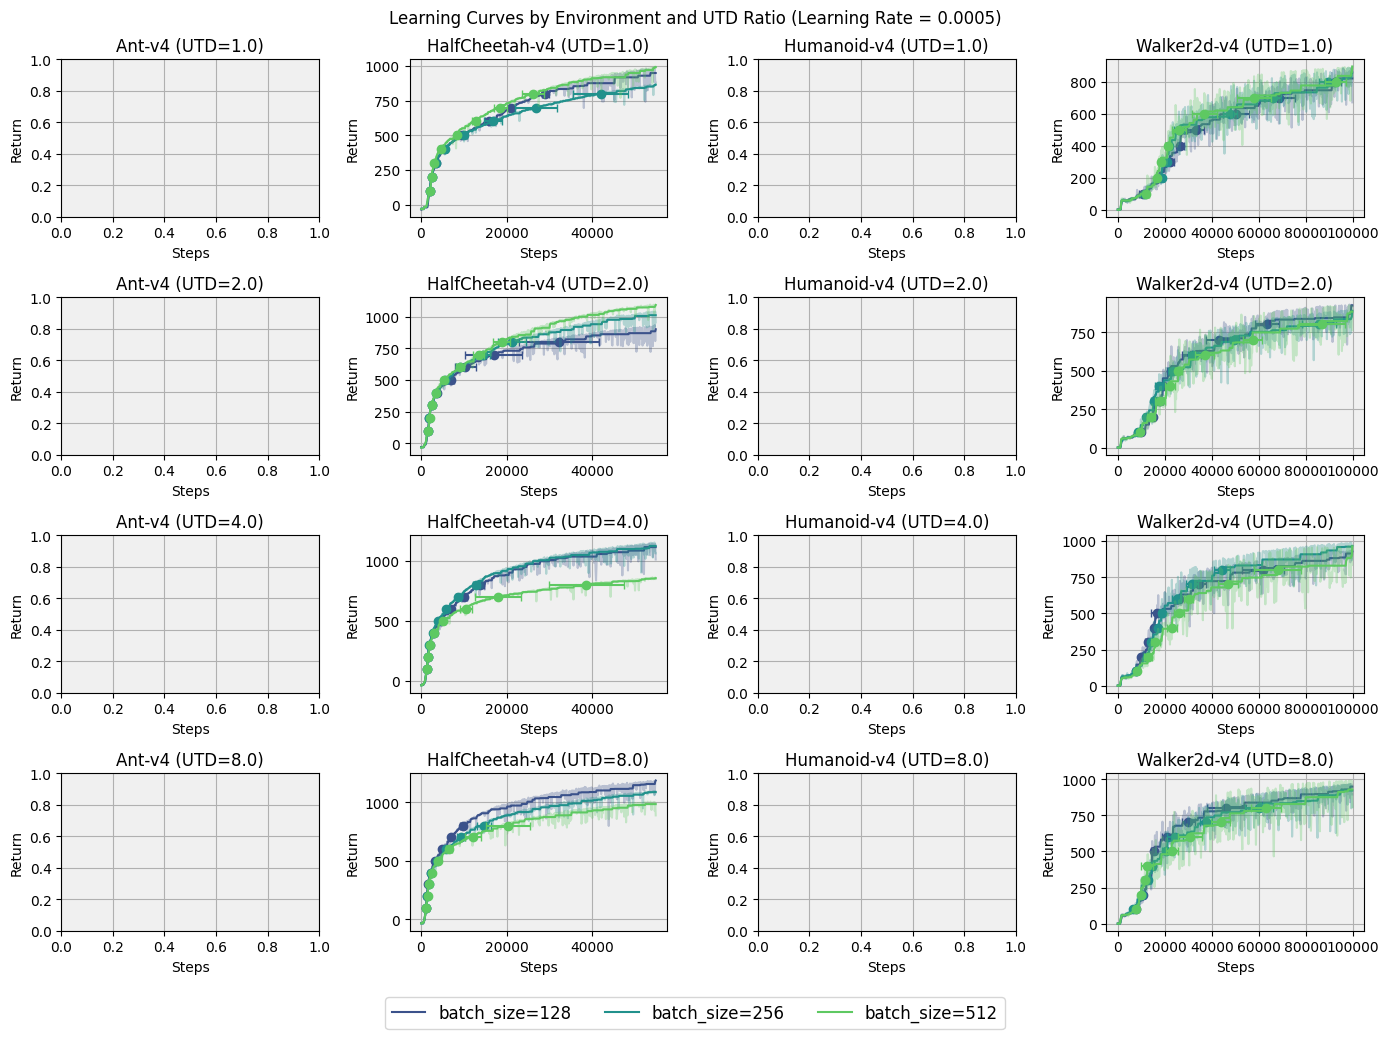

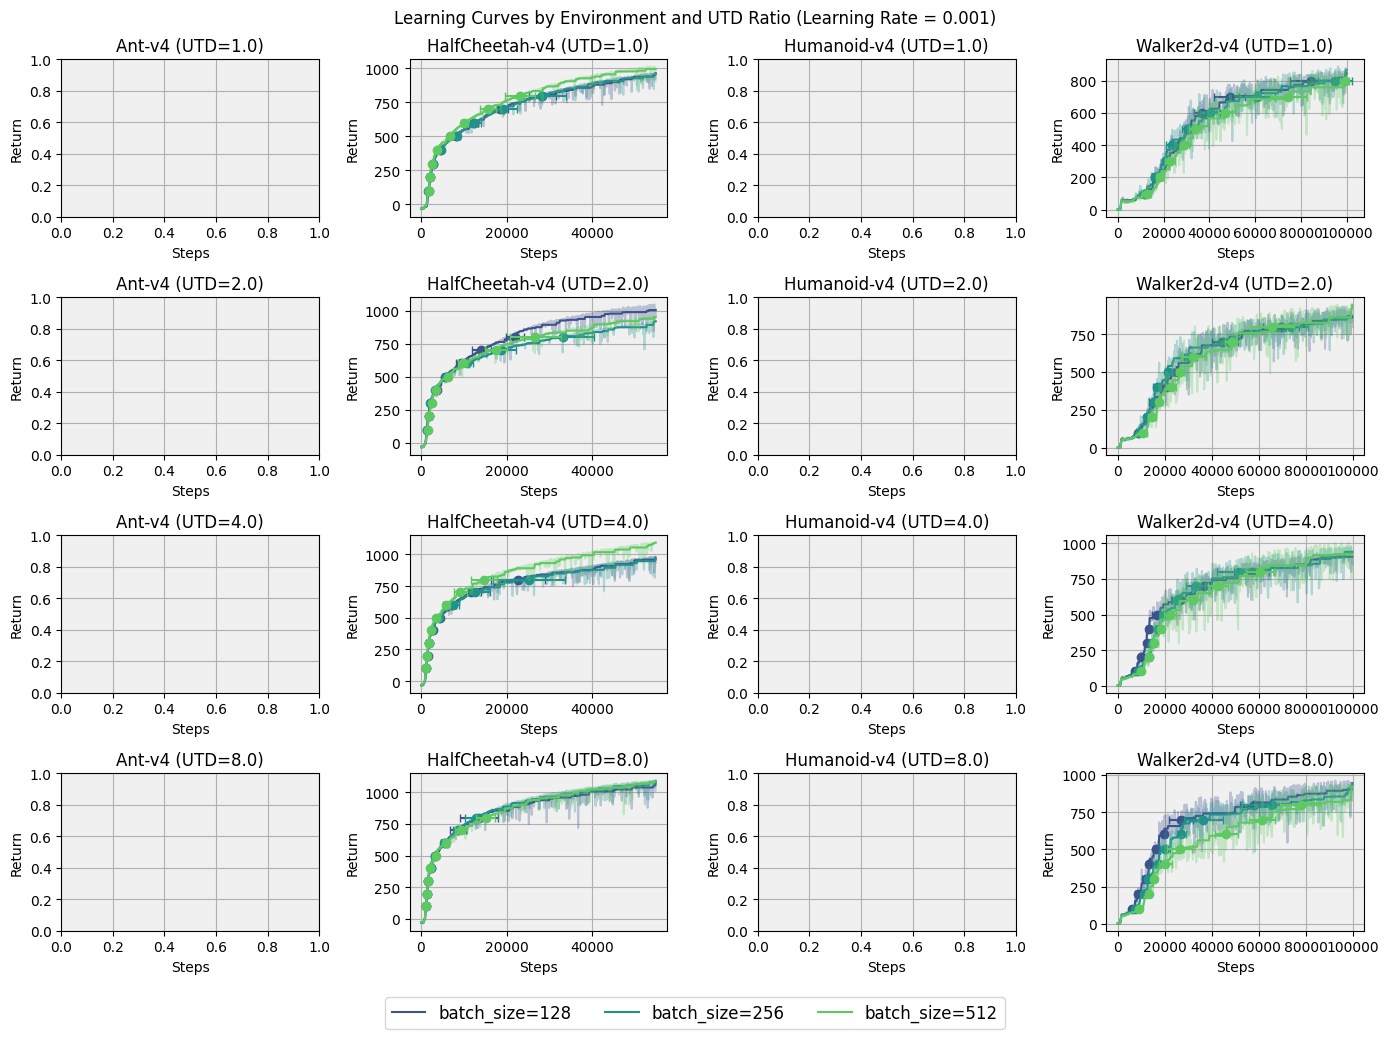

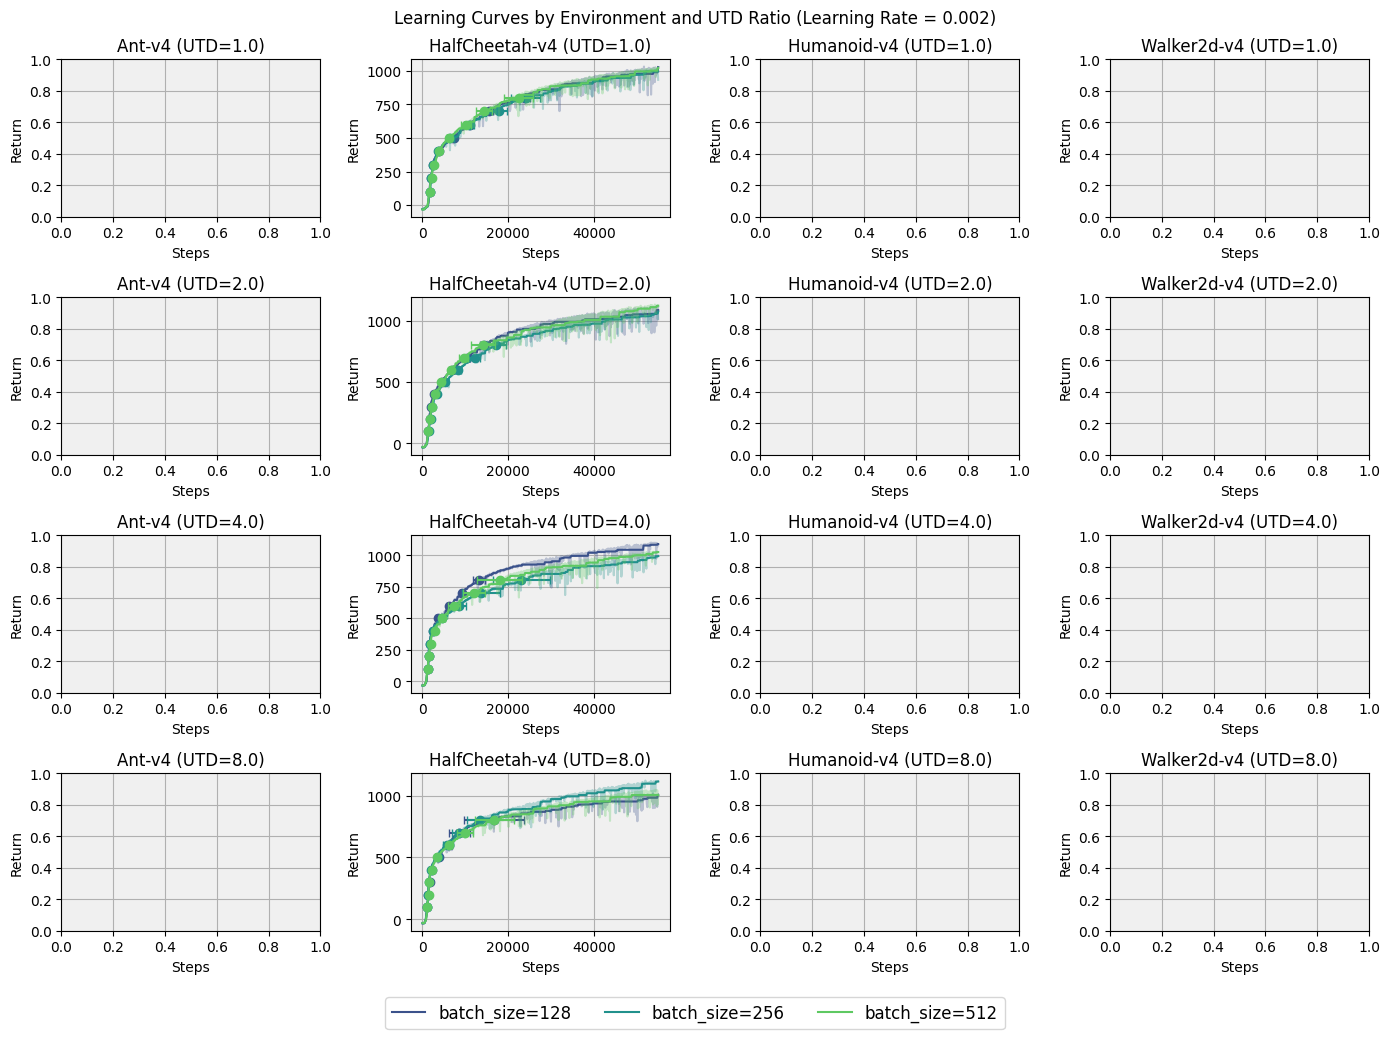

In [4]:
plot_per_learning_rate(grid_search_df, config.thresholds)

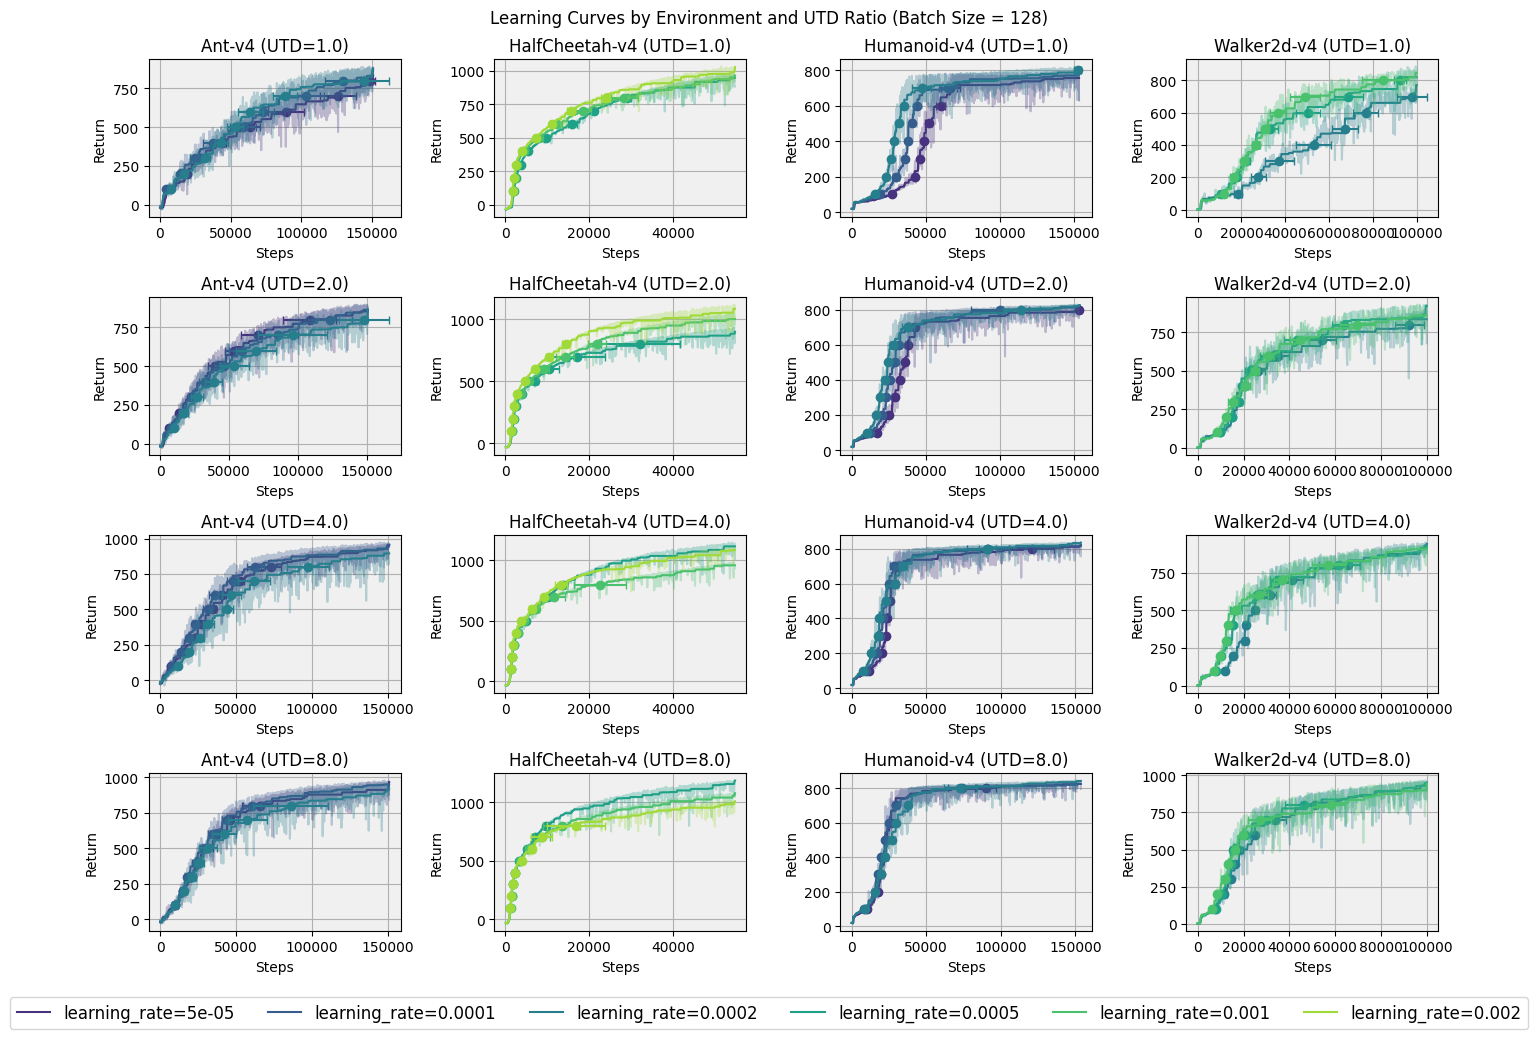

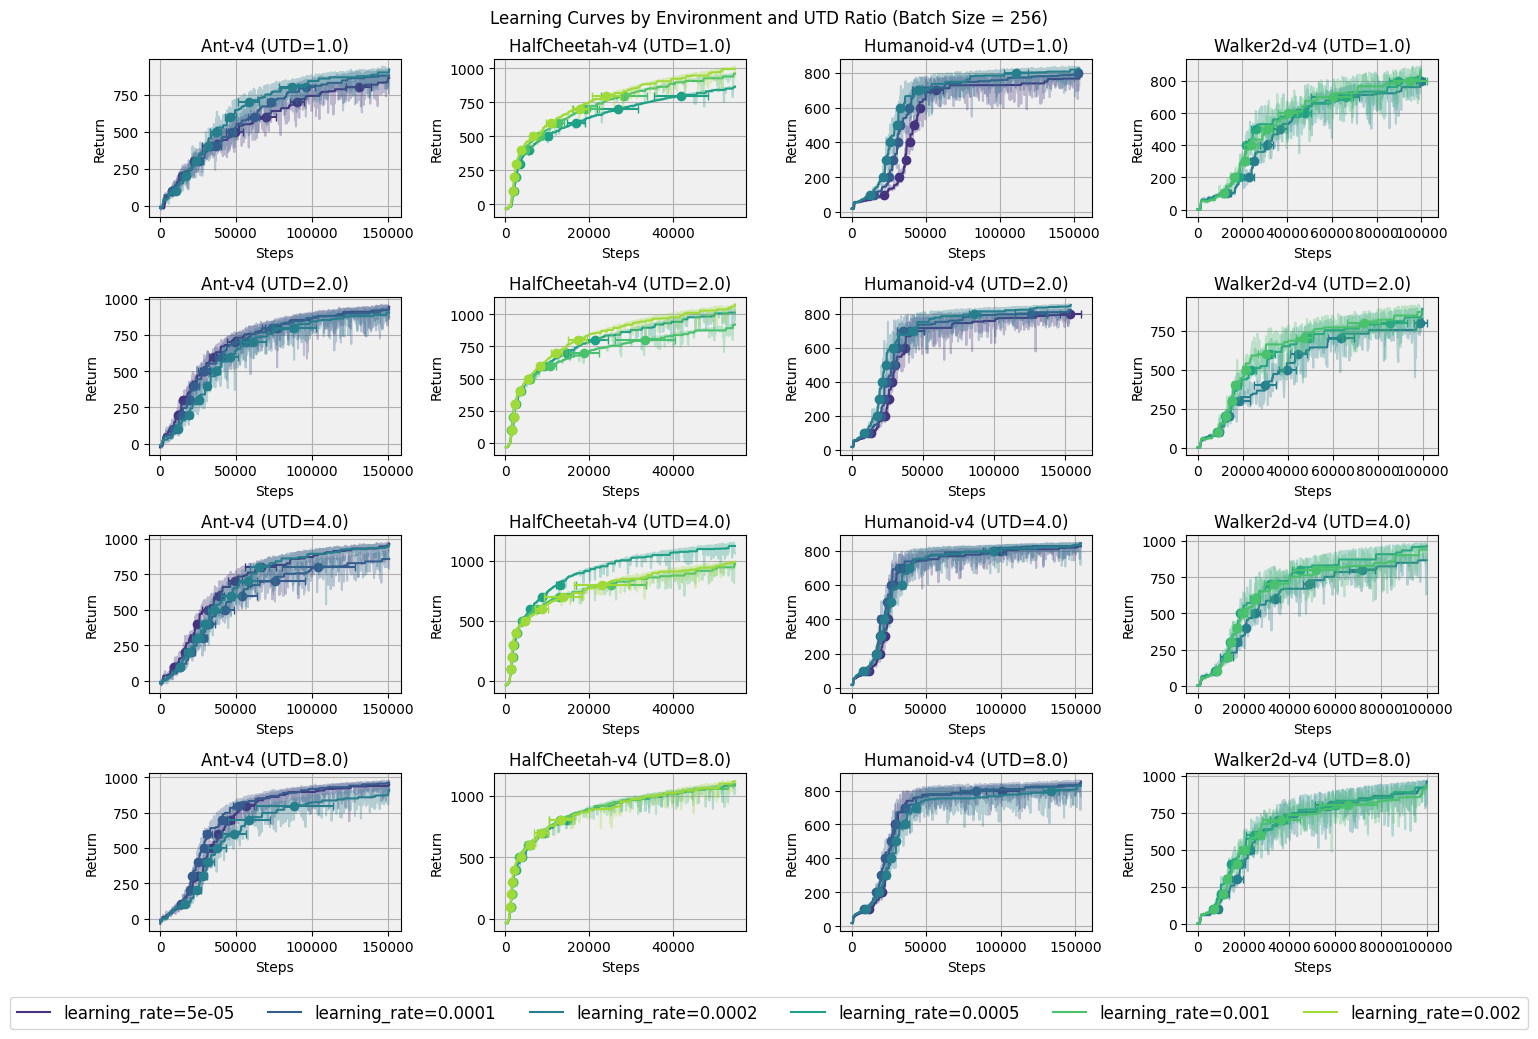

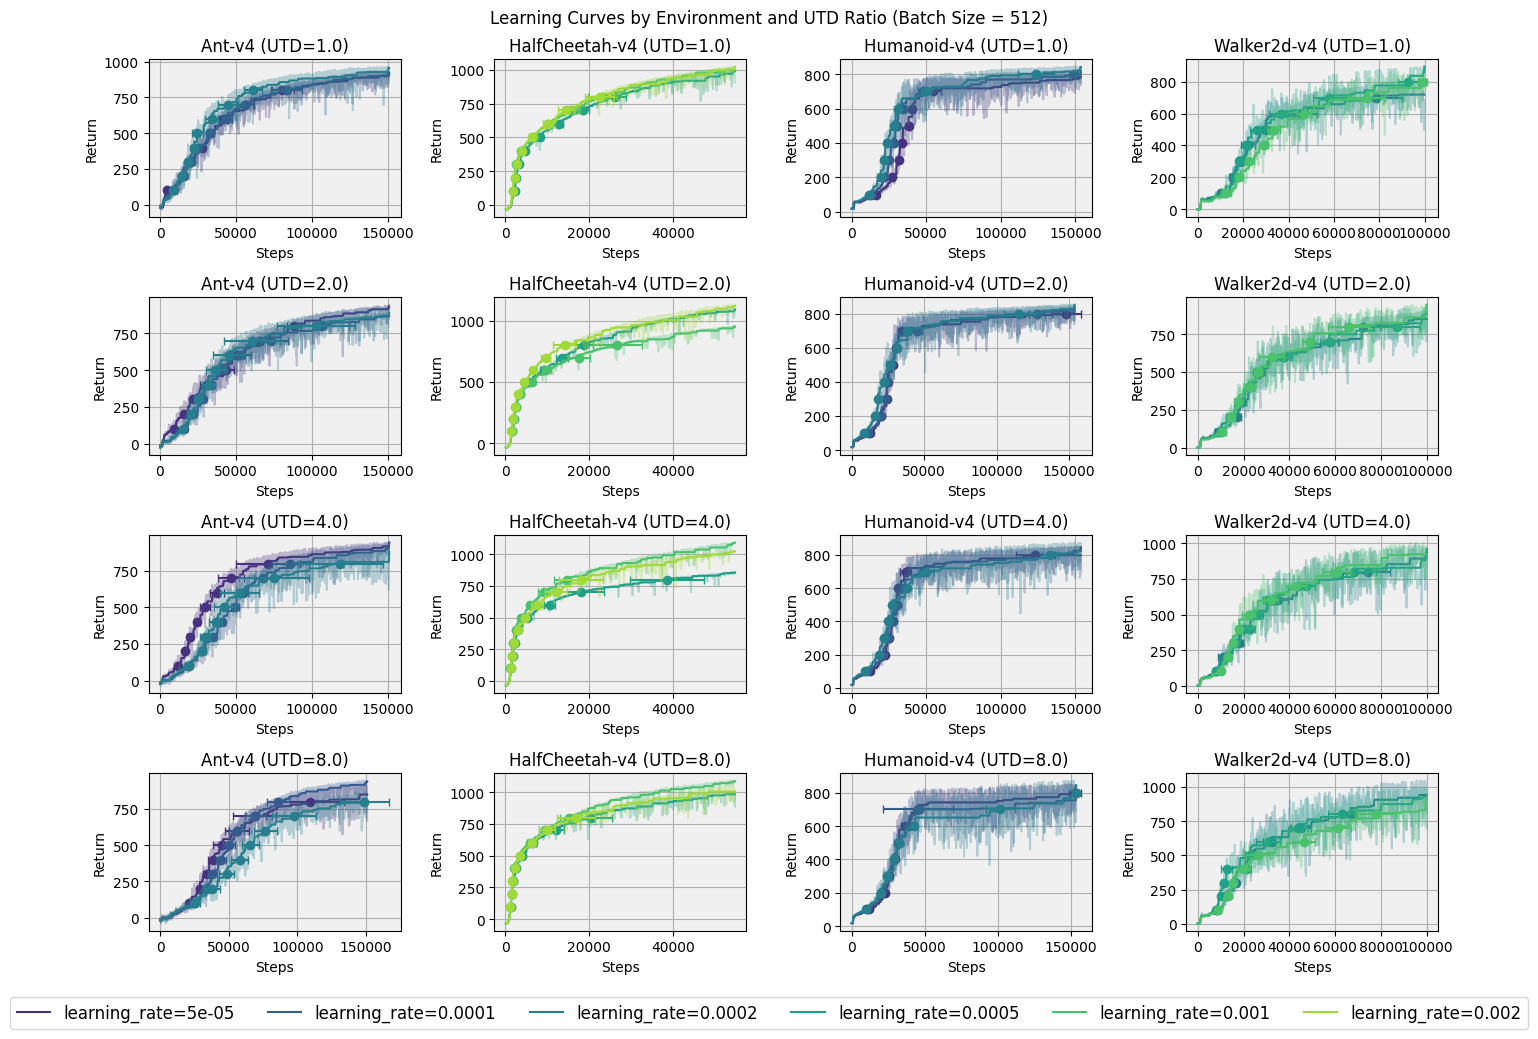

In [5]:
plot_per_batch_size(grid_search_df, config.thresholds)

# Bootstrapping

In [6]:
best_lr = grid_best_uncertainty_lr(grid_search_df, print_pivot=True)


Best learning_rate:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
batch_size     128     256     512            128     256     512         128     256     512         128     256     512
utd                                                                                                                      
1.0e+00    1.0e-04 2.0e-04 2.0e-04        2.0e-03 2.0e-03 2.0e-03     2.0e-04 2.0e-04 2.0e-04     1.0e-03 5.0e-04 5.0e-04
2.0e+00    5.0e-05 1.0e-04 5.0e-05        2.0e-03 2.0e-03 2.0e-03     1.0e-04 2.0e-04 2.0e-04     5.0e-04 1.0e-03 1.0e-03
4.0e+00    1.0e-04 2.0e-04 5.0e-05        2.0e-03 5.0e-04 1.0e-03     2.0e-04 2.0e-04 5.0e-05     1.0e-03 5.0e-04 1.0e-03
8.0e+00    1.0e-04 1.0e-04 1.0e-04        5.0e-04 1.0e-03 1.0e-03     2.0e-04 1.0e-04 5.0e-05     5.0e-04 2.0e-04 5.0e-04

Uncertainty-Corrected Best learning_rate:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4     

In [7]:
best_bs = grid_best_uncertainty_bs(grid_search_df, print_pivot=True)


Best batch_size:
env_name       Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
learning_rate 5.0e-05 1.0e-04 2.0e-04        5.0e-04 1.0e-03 2.0e-03     5.0e-05 1.0e-04 2.0e-04     2.0e-04 5.0e-04 1.0e-03
utd                                                                                                                         
1.0e+00       5.1e+02 5.1e+02 5.1e+02        5.1e+02 5.1e+02 5.1e+02         NaN 5.1e+02 2.6e+02     2.6e+02 2.6e+02 1.3e+02
2.0e+00       2.6e+02 2.6e+02 2.6e+02        5.1e+02 1.3e+02 5.1e+02     5.1e+02 1.3e+02 2.6e+02     5.1e+02 1.3e+02 5.1e+02
4.0e+00       2.6e+02 1.3e+02 2.6e+02        2.6e+02 5.1e+02 1.3e+02     2.6e+02 1.3e+02 1.3e+02     1.3e+02 2.6e+02 2.6e+02
8.0e+00       2.6e+02 2.6e+02 1.3e+02        1.3e+02 2.6e+02 2.6e+02     1.3e+02 1.3e+02 1.3e+02     1.3e+02 1.3e+02 1.3e+02

Uncertainty-Corrected Best batch_size:
env_name       Ant-v4                 HalfCheetah-v4               

In [8]:
best_lr_bs = best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_optimal, include_groups=False).reset_index()
best_lr_bs = compute_bootstrap_averages(best_lr, best_bs, best_lr_bs)

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


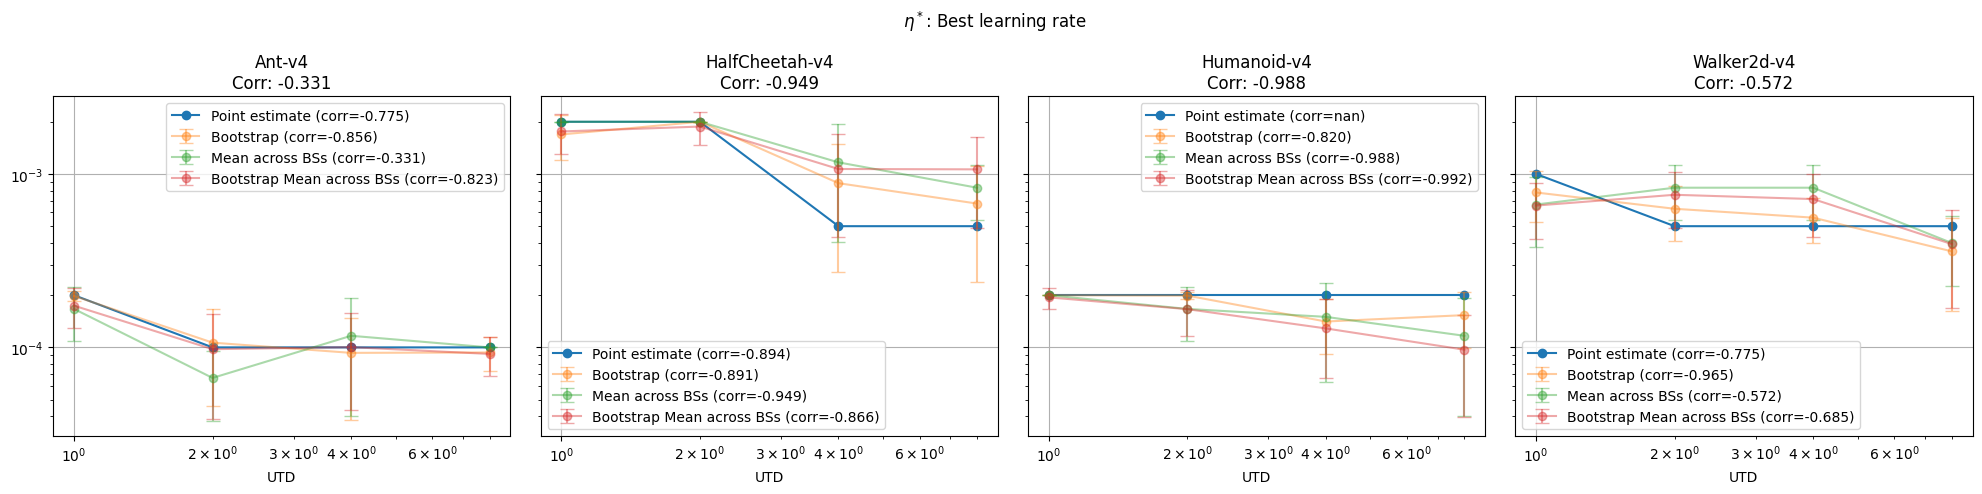

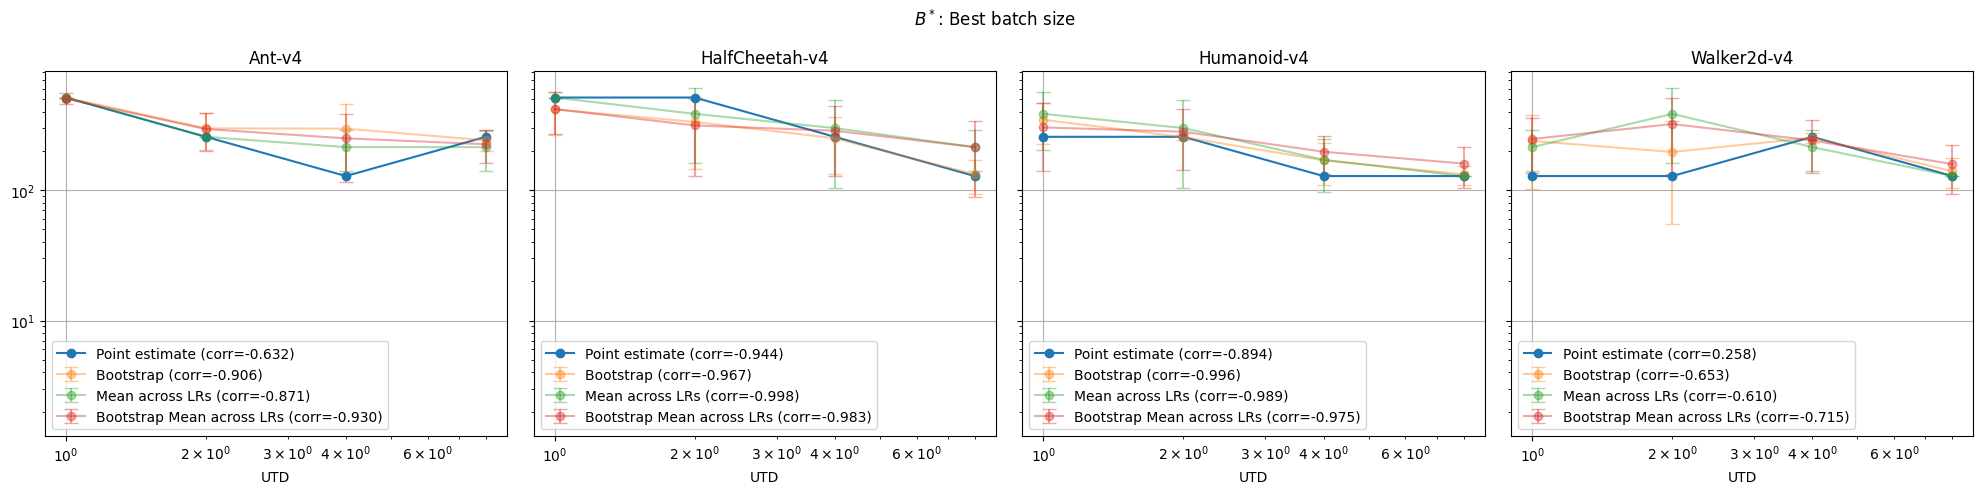

In [9]:
plot_bootstrap_average_params(best_lr_bs)

# Linear Fitting

Ant-v4: learning rate ~ 0.000157 * UTD^-0.397143
HalfCheetah-v4: learning rate ~ 0.001953 * UTD^-0.359423
Humanoid-v4: learning rate ~ 0.000198 * UTD^-0.297448
Walker2d-v4: learning rate ~ 0.000680 * UTD^0.062339


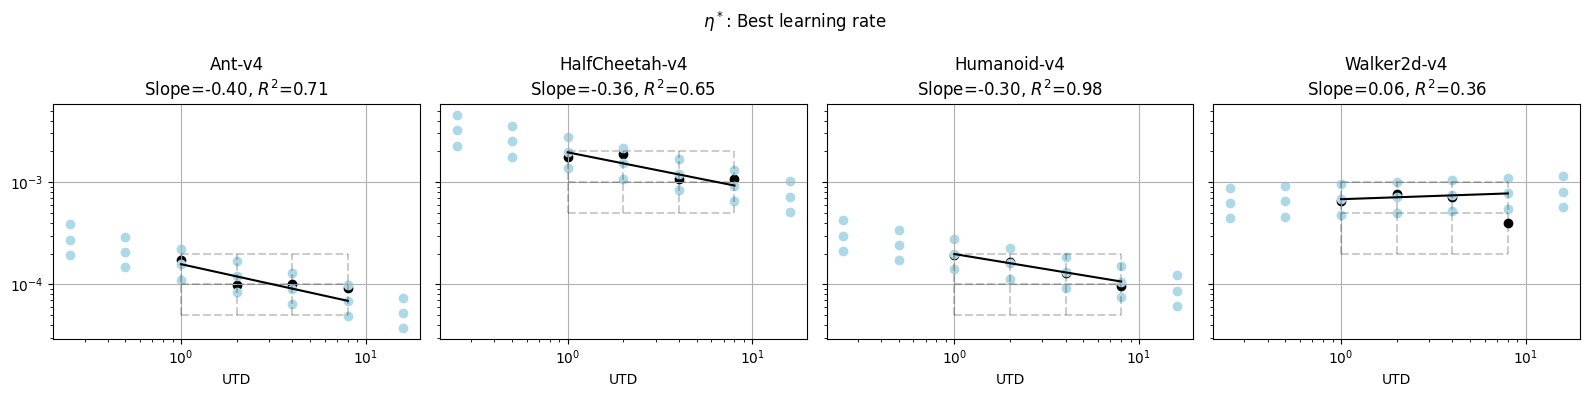

Ant-v4: batch size ~ 472.248364 * UTD^-0.506150
HalfCheetah-v4: batch size ~ 404.590511 * UTD^-0.276467
Humanoid-v4: batch size ~ 316.325514 * UTD^-0.309491
Walker2d-v4: batch size ~ 270.016171 * UTD^-0.017718


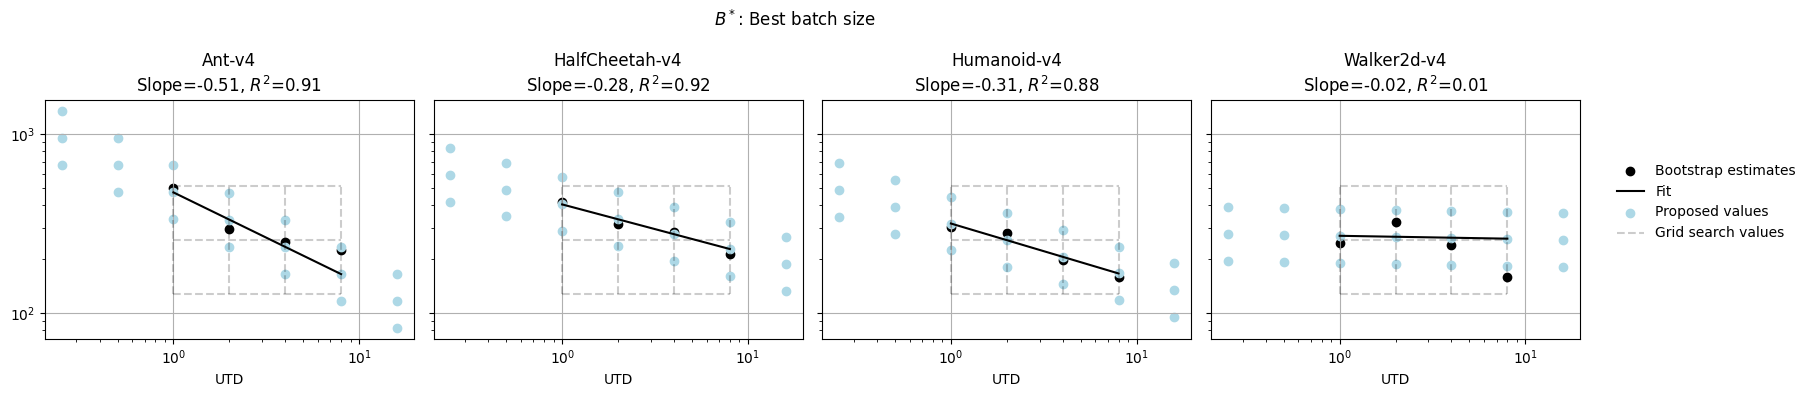

In [10]:
# Empirically, we find that using a shared slope does better.
(
    proposed_lr_values_separate,
    proposed_bs_values_separate,
    lr_slopes_separate,
    lr_intercepts_separate,
    bs_slopes_separate,
    bs_intercepts_separate
) = linear_fit_separate(
    config.utds_to_predict, grid_search_df, best_lr_bs, save_path=None, plot=True
)

Ant-v4: lr ~ 0.000150 * UTD^-0.284872
HalfCheetah-v4: lr ~ 0.001871 * UTD^-0.284872
Humanoid-v4: lr ~ 0.000191 * UTD^-0.284872
Walker2d-v4: lr ~ 0.000824 * UTD^-0.284872


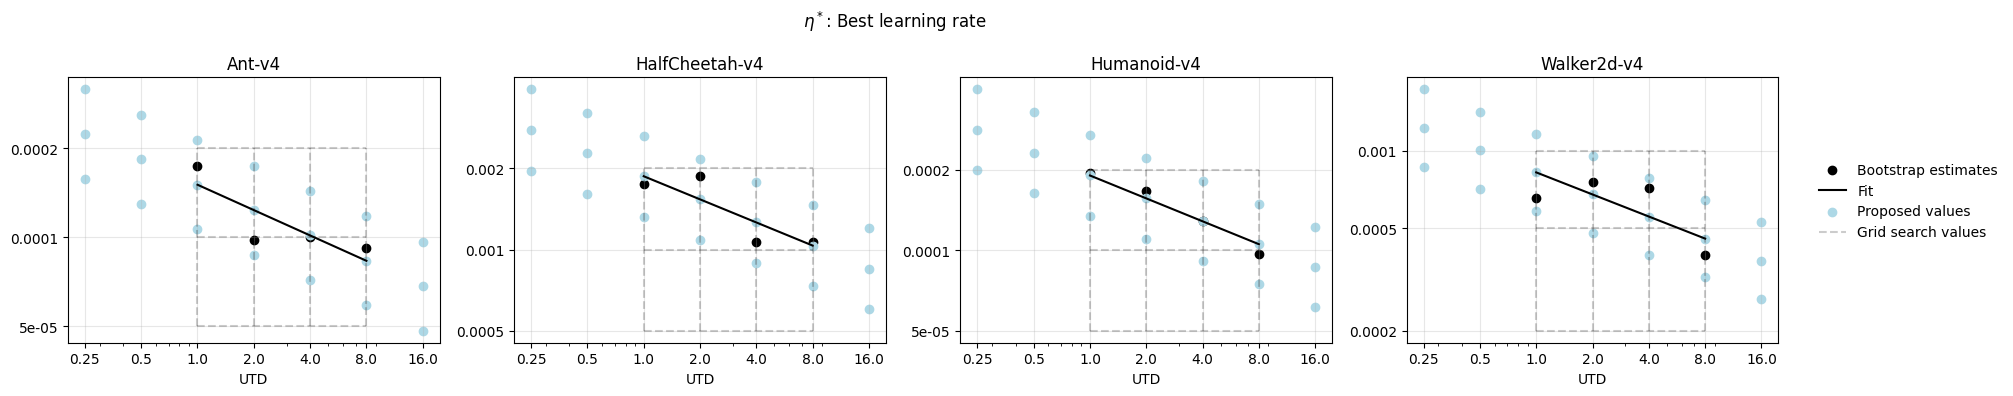

Ant-v4: batch size ~ 415.838220 * UTD^-0.309609
HalfCheetah-v4: batch size ~ 412.012557 * UTD^-0.309609
Humanoid-v4: batch size ~ 313.161763 * UTD^-0.309609
Walker2d-v4: batch size ~ 322.787915 * UTD^-0.309609


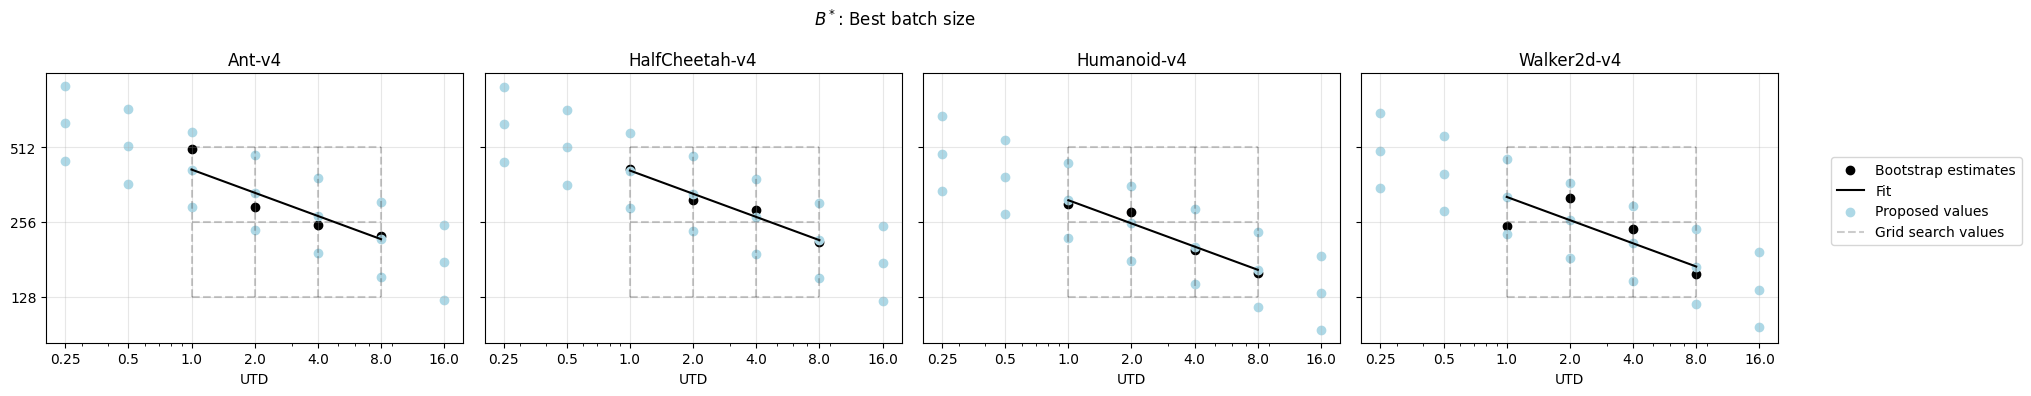

In [11]:
(
    proposed_lr_values_shared,
    proposed_bs_values_shared,
    lr_shared_slope_shared,
    lr_env_intercepts_shared,
    bs_shared_slope_shared,
    bs_env_intercepts_shared
) = linear_fit_shared(
    config.utds_to_predict, grid_search_df, best_lr_bs, save_path=name, plot=True
)


In [12]:
pd.options.display.float_format = '{:.2e}'.format
proposed_values_df = tabulate_proposed_params(
    config.utds_to_predict, 
    proposed_lr_values_shared, 
    proposed_bs_values_shared, 
    save_path=name
)
baseline_values_df = tabulate_baseline_params(
    config.utds_to_predict, 
    grid_search_df, 
    save_path=name
)

Baseline based on UTD 2.0


/home/preston/value-scaling-workflow-private/qscaled/save_params.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utd_data['last_crossing'] = utd_data['crossings'].apply(lambda x: x[-1])


In [13]:
proposed_values_df

Environment      UTD  Learning Rate  Learning Rate x√2  \
0        Ant-v4 1.00e+00       2.23e-04           3.16e-04   
1        Ant-v4 2.00e+00       1.83e-04           2.59e-04   
2        Ant-v4 4.00e+00       1.50e-04           2.13e-04   
3        Ant-v4 8.00e+00       1.23e-04           1.75e-04   
4        Ant-v4 1.00e+00       2.23e-04           3.16e-04   
..          ...      ...            ...                ...   
59  Walker2d-v4 8.00e+00       6.76e-04           9.56e-04   
60  Walker2d-v4 1.00e+00       1.22e-03           1.73e-03   
61  Walker2d-v4 2.00e+00       1.00e-03           1.42e-03   
62  Walker2d-v4 4.00e+00       8.24e-04           1.17e-03   
63  Walker2d-v4 8.00e+00       6.76e-04           9.56e-04   

    Learning Rate x√0.5  Batch Size  Batch Size x√2  Batch Size x√0.5  \
0              1.58e-04         639             903               452   
1              1.30e-04         515             729               364   
2              1.06e-04         416             588               294   
3              8.73e-05         336             475               237   
4              1.58e-04         639             903               452   
..                  ...         ...             ...               ...   
59             4.78e-04         260             368               184   
60             8.65e-04         496             701               351   
61             7.10e-04         400             566               283   
62             5.83e-04         323             456               228   
63             4.78e-04         260             368               184   

    Batch Size(rounded)  Batch Size x√2(rounded)  Batch Size x√0.5(rounded)  
0                   640                      896                        448  
1                   512                      736                        368  
2                   416                      592                        288  
3                   336                      480                        240  
4                   640                      896                        448  
..                  ...                      ...                        ...  
59                  256                      368                        192  
60                  496                      704                        352  
61                  400                      560                        288  
62                  320                      448                        224  
63                  256                      368                        192  

[64 rows x 11 columns]

In [14]:
baseline_values_df

Environment      UTD  Learning Rate  Batch Size
0           Ant-v4 2.50e-01       1.00e-04         256
1           Ant-v4 5.00e-01       1.00e-04         256
2           Ant-v4        1       1.00e-04         256
3           Ant-v4        2       1.00e-04         256
4           Ant-v4        4       1.00e-04         256
5           Ant-v4        8       1.00e-04         256
6           Ant-v4       16       1.00e-04         256
7   HalfCheetah-v4 2.50e-01       2.00e-03         512
8   HalfCheetah-v4 5.00e-01       2.00e-03         512
9   HalfCheetah-v4        1       2.00e-03         512
10  HalfCheetah-v4        2       2.00e-03         512
11  HalfCheetah-v4        4       2.00e-03         512
12  HalfCheetah-v4        8       2.00e-03         512
13  HalfCheetah-v4       16       2.00e-03         512
14     Humanoid-v4 2.50e-01       2.00e-04         256
15     Humanoid-v4 5.00e-01       2.00e-04         256
16     Humanoid-v4        1       2.00e-04         256
17     Humanoid-v4        2       2.00e-04         256
18     Humanoid-v4        4       2.00e-04         256
19     Humanoid-v4        8       2.00e-04         256
20     Humanoid-v4       16       2.00e-04         256
21     Walker2d-v4 2.50e-01       5.00e-04         128
22     Walker2d-v4 5.00e-01       5.00e-04         128
23     Walker2d-v4        1       5.00e-04         128
24     Walker2d-v4        2       5.00e-04         128
25     Walker2d-v4        4       5.00e-04         128
26     Walker2d-v4        8       5.00e-04         128
27     Walker2d-v4       16       5.00e-04         128

# Data Efficiency

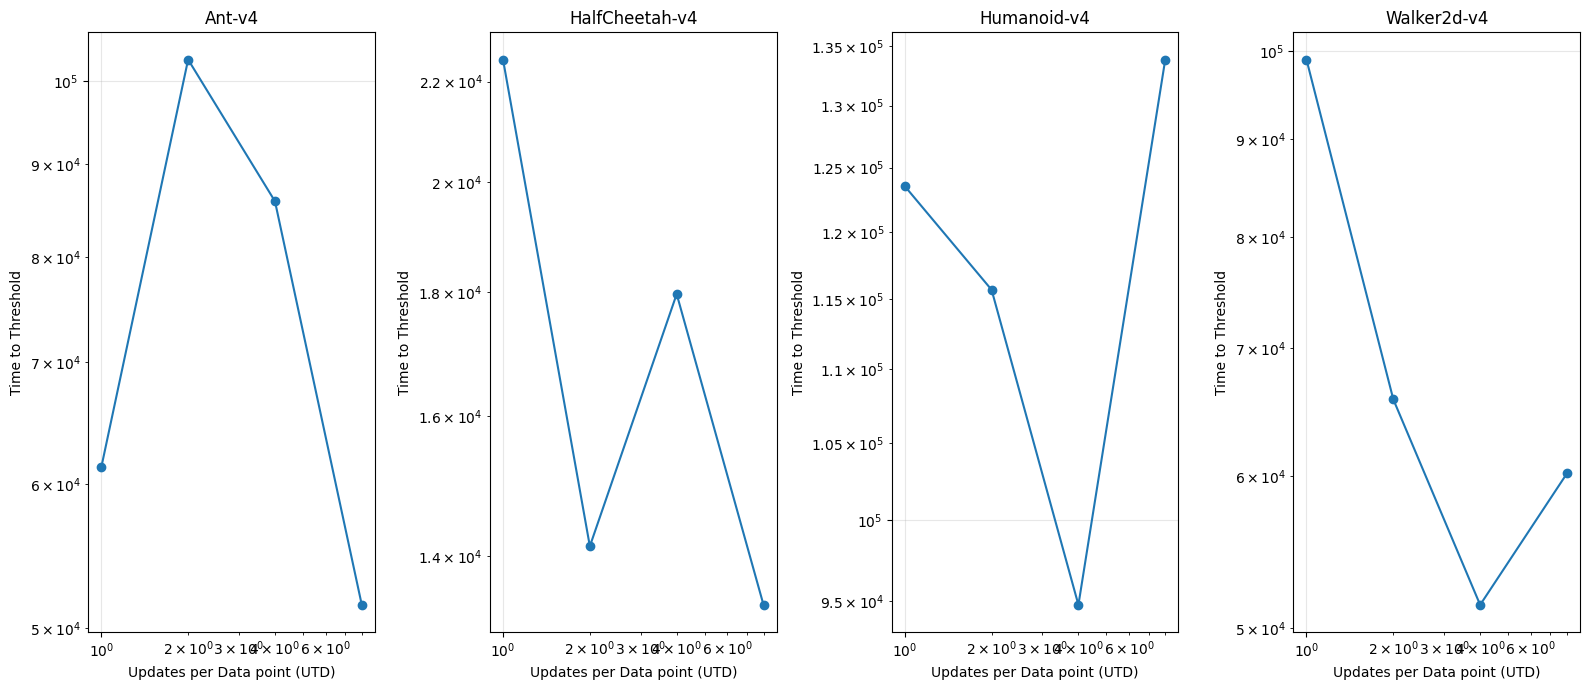

In [15]:
closest_fit_steps_per_utd = plot_closest_data_efficiency(
    grid_search_df, 
    proposed_lr_values_shared, 
    proposed_bs_values_shared
)

/home/preston/value-scaling-workflow-private/utils/fitting.py:6: RuntimeWarning: invalid value encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/value-scaling-workflow-private/utils/fitting.py:6: RuntimeWarning: overflow encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


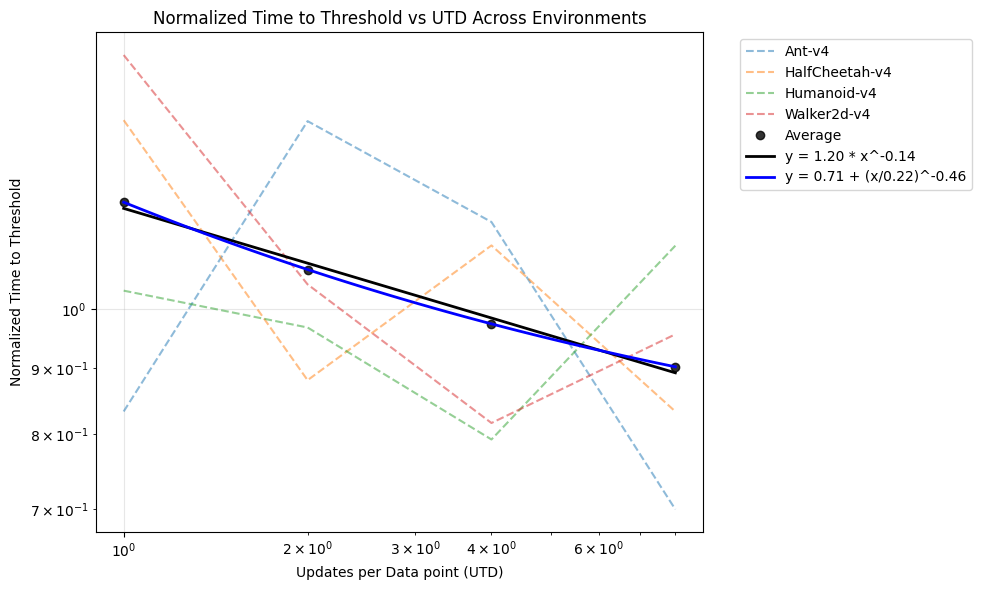

In [16]:
plot_averaged_data_efficiency(closest_fit_steps_per_utd)